# Data Science for Drug Discovery Practical
## Fabian and Elizabeth

List of imports are comprehensive. Also make sure no existing database file exists.

In [1]:
# Imports required for the practical are comprehensive
import re
import os
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit.Chem import Descriptors, AllChem
from rdkit.DataManip.Metric import GetTanimotoSimMat
import numpy as np
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from plotnine import *
from plotnine.ggplot import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
if os.path.exists("./MPro_database.db"):
  os.remove("./MPro_database.db")

## Creating a database and populating it

In [3]:
# Create database file and establish a connection to it
conn = sqlite3.connect("./MPro_database.db")
drop_order = ('compounds', 'assays')

In [4]:
# Create a database which will store compounds and their SMILES string
conn.execute('''
CREATE TABLE compounds
(
    CID PRIMARY KEY,
    SMILES
)
        ''')

# Read in the molecular data and save it to the columns of the dataframe
df = pd.read_csv('activity_data.csv')

for i in range(len(df)):
    row = df.iloc[i]
    values  =  (row['CID'], 
         row['SMILES']
        )
    conn.execute('INSERT INTO compounds (CID, SMILES) VALUES (?,?)',
        values)

In [5]:
# Creates and populates a table of assays, including a foreign key linking the assays to the compounds table
conn.execute('''
CREATE TABLE assays
(
    CID PRIMARY KEY,
    canonical_CID,
    r_inhibition_at_20_uM,
    r_inhibition_at_50_uM,
    r_avg_IC50,
    f_inhibition_at_20_uM,
    f_inhibition_at_50_uM,
    f_avg_IC50,
    f_avg_pIC50,
    relative_solubility_at_20_uM,
    relative_solubility_at_100_uM,
    trypsin_IC50,
    NMR_std_ratio,
    acrylamide,
    chloroacetamide,
    series,
    frag_id,
    compoundID,
    FOREIGN KEY (CompoundID) REFERENCES compounds (CID)
)
        ''')


In [6]:
# Populate the assay table with data from the csv file (with smiles strings removed)
df_short = df.iloc[:,1:]

for i in range(len(df_short)):
    row = df_short.iloc[i]
    values = []
    
    for element in row[:]:
        values.append(element)
    values.append(row[0])
    conn.execute('INSERT INTO assays (CID, canonical_CID, r_inhibition_at_20_uM, r_inhibition_at_50_uM, r_avg_IC50, f_inhibition_at_20_uM, f_inhibition_at_50_uM, f_avg_IC50, f_avg_pIC50, relative_solubility_at_20_uM, relative_solubility_at_100_uM, trypsin_IC50, NMR_std_ratio, acrylamide, chloroacetamide, series, frag_id, compoundID) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)',
             (values)
                )

In [7]:
# Create functions which retrieve either SMILES or assay data from the databases uses SQL functions
def retrieve_SMILES(compoundID: str):
    list_smiles = []
    SMILES = conn.execute('''
        SELECT SMILES
        FROM compounds
        WHERE 
            CID = ?
    ''', (compoundID,))
    for sm in SMILES:
        list_smiles.append(sm)
    return (list_smiles[0][0])
        
def retrieve_assays(compoundID: str):
    list_assays = []
    ASSAYS = conn.execute('''SELECT *
        FROM assays
        INNER JOIN compounds
        ON assays.compoundID = compounds.CID
        WHERE compounds.CID = ?
    ''', (compoundID,))
    for assay in ASSAYS:
        list_assays.append(assay)
    return (list_assays[0][2:-4])

# Demonstrate we can retrieve the assay data and SMILES string from an ID

print(retrieve_SMILES('MAT-POS-be048f2c-5'))
print(retrieve_assays('MAT-POS-be048f2c-5'))

CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1
(None, None, None, None, None, 0.297012069374338, None, None, None, None, None, 0, 0, '3-aminopyridine-like')


## Consideration of molecular properties
The Limpinski five criteria outline 5 properties which suggest a molecule will be a good therapeutic.

number of compounds that satisfy all rules: 1525 . That violate only one: 1950


/home/sabsr3/software_engineering/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


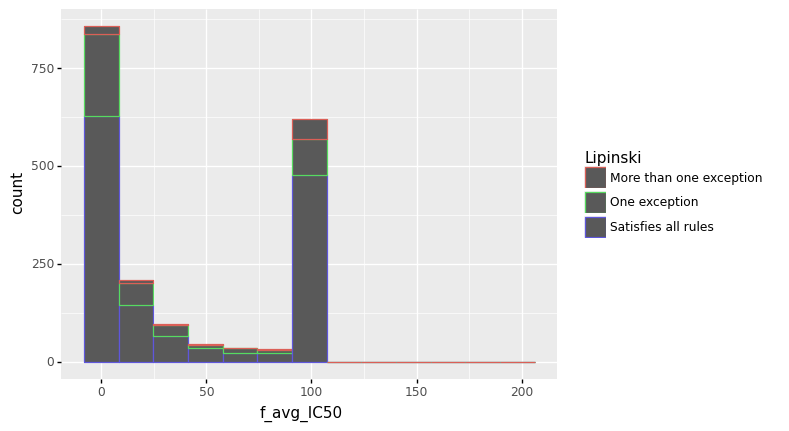

<ggplot: (8738881967153)>

In [8]:
list_smiles = []
SMILES = conn.execute('''
    SELECT SMILES 
    FROM compounds
''')

properties = {}
for sm in SMILES:
    list_smiles.append(sm)

for sm in list_smiles:

    m = rdkit.Chem.MolFromSmiles(sm[0])

    HAcceptors = False
    HDonors = False
    MW = False
    LogP = False

    if Descriptors.NumHDonors(m) <= 5:
        HDonors = True
    if Descriptors.NumHAcceptors(m) <= 10:
        HAcceptors = True
    if Descriptors.MolWt(m) < 500:
        MW = True
    if Descriptors.MolLogP(m) < 5:
        LogP = True
    properties[sm[0]] = [HAcceptors,HDonors,MW,LogP]


number of compounds that satisfy all rules: 1525 . That violate only one: 1950


/home/sabsr3/software_engineering/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


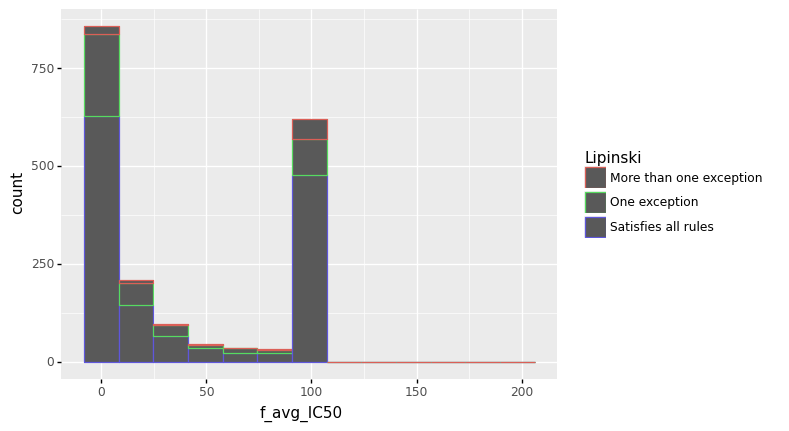

<ggplot: (8738872053363)>

In [25]:
df_smiles_index = df.set_index('SMILES')
df_properties = pd.DataFrame.from_dict(properties,orient='index', columns=['HAcceptors','HDonors','MW','LogP'])
df_5 = df_properties.loc[df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['MW'] & df_properties['LogP']]
df_4 = df_properties.loc[(df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['MW']) |
                        (df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['LogP']) |
                        (df_properties['HAcceptors'] & df_properties['MW'] & df_properties['LogP']) |
                        (df_properties['HDonors'] & df_properties['MW'] & df_properties['LogP'])]
print('number of compounds that satisfy all rules:', len(df_5), '. That violate only one:', len(df_4))
df_smiles_index['Lipinski'] = np.empty(len(df_smiles_index))
df_smiles_index['Lipinski'] = 'More than one exception'
df_smiles_index.loc[df_4.index,'Lipinski'] = 'One exception'
df_smiles_index.loc[df_5.index,'Lipinski'] = 'Satisfies all rules'


# Dfs only containing assays for the compounds that satisfy all Lipinski
df_5_assays = df_smiles_index.loc[df_5.index] #.set_index('CID', inplace=True)
# satisfy 3 of the 4
df_4_assays = df_smiles_index.loc[df_4.index]

# 0 in the histogram means there was no data
df_smiles_index_no_nan = df_smiles_index[['f_avg_IC50','Lipinski']].dropna()
(ggplot(df_smiles_index_no_nan, aes(x='f_avg_IC50', color='Lipinski')) + geom_histogram())

In [9]:
descriptor_names = list(rdkit.Chem.rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdkit.Chem.rdMolDescriptors.Properties(descriptor_names)

def mol_to_descriptors(mol):
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors
descriptors_dict = {}

for index, row in df.iterrows():
    id = row['CID']
    smiles_str = retrieve_SMILES(id)
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    descriptors_dict[id] = np.array(mol_to_descriptors(mol))
(descriptors_df) = pd.DataFrame(data=descriptors_dict.values(), index = descriptors_dict.keys())

## Molecular fingerprint
Rdkit has compatibility to save a bit representation of the molecular fingerprint. Morgan or circular fingerprints take into account topological information within a given radius (here we take r=2) so take into account structural properties as well as the connectivity of atoms.

In [10]:
fingerprint_dict = {}
fingerprint_bit_list =[]

for index, row in df.iterrows():
    id = row['CID']
    smiles_str = retrieve_SMILES(id)
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    fingerprint_dict[id] =  AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    fingerprint_bit_list.append(np.array(fingerprint_dict[id]))

In [11]:
# Use the inbuilt dice similarity metric to create a distance matrix between the compounds
num_data = index
sim_matrix_dice = np.zeros((num_data+1, num_data+1))
sim_matrix_tanimoto = np.zeros((num_data+1, num_data+1))
id_list = fingerprint_dict.keys()

for i, i_id in enumerate(id_list):
    for j, j_id in enumerate(id_list):
        sim_matrix_dice[i, j] = rdkit.DataStructs.FingerprintSimilarity(fingerprint_dict[i_id], 
                                fingerprint_dict[j_id], metric=rdkit.DataStructs.DiceSimilarity)
        sim_matrix_tanimoto[i, j] = GetTanimotoSimMat([fingerprint_dict[i_id], 
                                fingerprint_dict[j_id]])[0]


/tmp/ipykernel_8400/1268671327.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


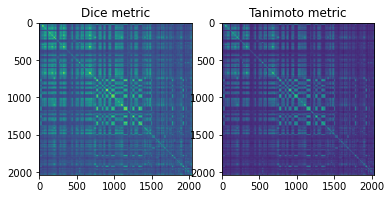

In [12]:
# Output this similarity matrix using the dice metric
fig, ax = plt.subplots(1,2)
ax[0].imshow(sim_matrix_dice)
ax[0].set_title('Dice metric')
ax[1].imshow(sim_matrix_tanimoto)
ax[1].set_title('Tanimoto metric')
fig.show()

We see up to a scaling of the similarity matrix the overall pattern is very similar. The Tanimoto metric calculates the ratio of the size of the intersection of sets to their union, so if x out of 2048 bits are in common, the metric returns a value of x/(4096 - x). The dice metric calculates the ratio of intersection size to the sum of the individual set sizes, so would be 2x/4096.

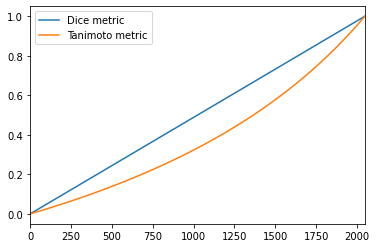

In [42]:
xx = np.linspace(0,2048,100)
dice_func = 2* xx / 4096
tanimoto_func = xx/(4096 - xx)
plt.plot(xx, dice_func, label='Dice metric')
plt.plot(xx, tanimoto_func, label='Tanimoto metric')
plt.xlim((0, 2048))
plt.legend()

## Clustering 
Using the similarity matrices for the fingerprints we can cluster the datapoints. We used the Affinity Propagation method from sklearn clustering that accepts a similarity matrix as input. This algorithmn is slow, but allows the number of clusters to be undetermined.

(array([ 3.,  6.,  5.,  1.,  5., 29.,  4., 13., 12., 11.,  3.,  4.,  2.,
         4.,  5., 11.,  5., 15., 28.,  6.,  2.,  4.,  4.,  6.,  8.,  5.,
        14., 15., 10.,  4., 10., 25., 11.,  3.,  4.,  7.,  6.,  4.,  5.,
         2.,  3.,  3.,  3.,  3.,  4.,  5.,  6.,  5.,  3.,  4.,  6., 13.,
         2., 15., 10.,  3.,  4., 27.,  4.,  3.,  6.,  8., 14., 26., 13.,
        16., 11.,  5.,  4.,  4., 17., 16.,  4., 12.,  9.,  3.,  2.,  3.,
        12.,  7.,  6., 26., 18., 12., 14.,  8., 19., 43.,  5.,  8., 16.,
         7.,  8., 12., 12.,  2., 24., 10., 29., 13., 16.,  9.,  8., 15.,
         3.,  8.,  8.,  8.,  7.,  4.,  7.,  9., 35., 12.,  5.,  4.,  8.,
         6.,  4.,  5.,  6.,  8., 14., 13., 15., 14.,  7.,  4., 15.,  6.,
         3.,  4., 33., 22., 43.,  7.,  2.,  5., 14.,  7.,  3.,  6.,  3.,
         4.,  2.,  9., 13., 12.,  6.,  5.,  3.,  4., 15.,  6.,  5., 10.,
         3.,  3., 19.,  9., 72.,  4., 26.,  3.,  2.,  5., 10., 60.,  4.,
         7.,  9.,  7.,  5.,  4.,  3., 12.,  4.,  3.

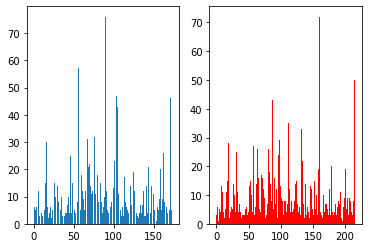

In [45]:
cluster_dice = AffinityPropagation(affinity = 'precomputed').fit_predict(sim_matrix_dice)
cluster_tanimoto = AffinityPropagation(affinity = 'precomputed').fit_predict(sim_matrix_tanimoto)
fig, ax = plt.subplots(1,2)
ax[0].hist(cluster_dice, bins=max(cluster))
ax[1].hist(cluster_tanimoto, bins=max(cluster), color='red')

There are differences in the clustering due to the two metrics used. However both have clusters limited to about 70 molecules, and the algorithm recommend about 200

## Calculating pIC50 values
The IC50 value most commonly present in the molecular data is the flourescent averaged data, so this was used for our model. As IC50 values depend on the experimental set up we cannot compare across assays.

In [16]:
# Create a table column for affinity values
conn.execute('''
    ALTER TABLE assays
    ADD pIC50''')

(array([673., 199., 202., 221., 220., 193., 154.,  36.,   2.,   1.]),
 array([3.70333481, 4.19038329, 4.67743178, 5.16448026, 5.65152874,
        6.13857723, 6.62562571, 7.1126742 , 7.59972268, 8.08677116,
        8.57381965]),
 <BarContainer object of 10 artists>)

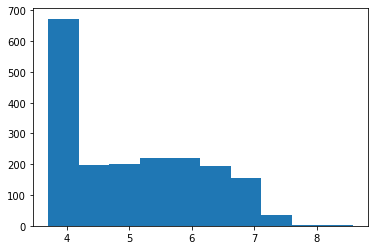

In [17]:
pIC50_list = []
pIC50_dict = {}

for index, row in df.iterrows():
    id = row['CID']
    fIC50 = retrieve_assays(id)[5]
    if not fIC50 is None:
        pIC50 = 6 - np.log10(fIC50)
        pIC50_list.append(pIC50)
        pIC50_dict[id] = [pIC50, min(round(pIC50),2), fingerprint_dict[id]]
    conn.execute('''INSERT INTO assays (pIC50) VALUES (?)''', (pIC50,))
plt.hist(pIC50_list)

### Choosing data to sample
There are 1901 samples with a flourescent pIC50 value. As pIC50 is dependent on the set-up, we can't compare pIC50 values across different assays. Due to the overrepresentation of molecules with a low binding affinity we want to sample more from the lower values, and hence include the rounded pIC50 value to stratify by. pIC50_dict gives us the molecules, with their pIC50 values.

In [ ]:
# Looking at the fingerprint data we removed bits which were common to all 1901 molecules,
# as these are zero-varince so would not inform our model.
short_fingerprint_dict = {}
id = list(pIC50_dict.keys())[0]

for i in range(len(fingerprint_dict[id])):
    sum = 0
    for key in pIC50_dict.keys():
        sum += fingerprint_dict[key][i]
    if sum == 0 or sum == len(pIC50_dict.keys()):
        continue
    for key in pIC50_dict.keys():
        if key in short_fingerprint_dict.keys():
            short_fingerprint_dict[key] += [(fingerprint_dict[key][i])]
        else:
            short_fingerprint_dict[key] = [(fingerprint_dict[key][i])]

In [19]:
# Data set containing all fingerprint data.
pIC50_df = pd.DataFrame(data=pIC50_dict.values(), index=pIC50_dict.keys(), columns=['pIC50', 'stratified value', 'fingerprint id'])
pIC50_lipinski = pIC50_df.loc[pIC50_df.index.isin(df_5_assays['CID'])]

# This data set contains reduced bit data from the molecules which satisfy all 5 lipinski conditions
pIC50_short = pd.DataFrame(data= short_fingerprint_dict.values(), index=pIC50_dict.keys())
pIC50_short_lipinski = pIC50_short.loc[pIC50_short.index.isin(df_5_assays['CID'])]

## Machine learning model

We considered three models for each set of data: a linear regression, a random forest, and a neural network. We measured success by the correlation of the test set with the predictions made by the model. By this metric the random forest algorithm was the most successful

First we looked at the fingerprint data:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(pIC50_short, pIC50_df['pIC50'], test_size=.1, random_state=0, stratify=pIC50_df['stratified value'])

# linear regression
regressor_ln = LinearRegression()  
regressor_ln.fit(X_train, y_train)
y_pred_ln = regressor_ln.predict(X_test)
# calculates R^2
print('Correlation training on fingerprint data')
print('linear regression:', regressor_ln.score(X_test,y_test))

# random forest
regr_rf = RandomForestRegressor(n_estimators=100)
regr_rf.fit(X_train, y_train)
y_pred_rf = regr_rf.predict(X_test)
# calculates R^2
print('random forest:', regr_rf.score(X_test,y_test))

# neural net
regr_nn = MLPRegressor()
regr_nn.fit(X_train, y_train)
y_pred_nn = regr_nn.predict(X_test)
# calculates R^2
print('neural net:',regr_nn.score(X_test,y_test))

Correlation training on fingerprint data
linear regression: -1.4400529373983518e+21
random forest: 0.596963312312254
neural net: 0.327325388727279


Now we filter by molecules which satisfy all five of the Lipinski values, ie train on molecules which should be good therapeutics. This reduces the number of molecules from 2000 to 1300 which we think cause the reduced accuracy in the test. 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(pIC50_short_lipinski, pIC50_lipinski['pIC50'], test_size=.1, random_state=0, stratify=pIC50_lipinski['stratified value'])

# linear regression
regressor_ln = LinearRegression()  
regressor_ln.fit(X_train, y_train)
y_pred_ln = regressor_ln.predict(X_test)
# calculates R^2
print('Correlation training on fingerprint data which satisfies Lipinski conditions')
print('linear regression:', regressor_ln.score(X_test,y_test))

# random forest
regr_rf = RandomForestRegressor(n_estimators=100)
regr_rf.fit(X_train, y_train)
y_pred_rf = regr_rf.predict(X_test)
# calculates R^2
print('random forest:', regr_rf.score(X_test,y_test))

# neural net
regr_nn = MLPRegressor()
regr_nn.fit(X_train, y_train)
y_pred_nn = regr_nn.predict(X_test)
# calculates R^2
print('neural net:',regr_nn.score(X_test,y_test))

Correlation training on fingerprint data which satisfies Lipinski conditions
linear regression: -5.5426883746218705e+20
random forest: 0.5104670810056549
neural net: 0.25648097407022175


Next we considered looking at the molecular properties of molecules, as described on rdkit

In [22]:
descriptor_names = list(rdkit.Chem.rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdkit.Chem.rdMolDescriptors.Properties(descriptor_names)

def mol_to_descriptors(mol):
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

descriptors_dict = {}

for index, row in df.iterrows():
    id = row['CID']
    smiles_str = retrieve_SMILES(id)
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    descriptors_dict[id] = np.array(mol_to_descriptors(mol))

descriptors_df = pd.DataFrame(data=descriptors_dict.values(), index = descriptors_dict.keys())
descriptors_df_short = descriptors_df.loc[pIC50_short.index]
descriptors_df_short_lipinski = descriptors_df_short.loc[pIC50_short.index.isin(df_5_assays['CID'])]

Now looking at descriptor values, while also filtering by Lipinski condition satisfcation

In [24]:
X_train, X_test, y_train, y_test = train_test_split(descriptors_df_short_lipinski, pIC50_lipinski['pIC50'], test_size=.1, random_state=0, stratify=pIC50_lipinski['stratified value'])


# linear regression
regressor_ln = LinearRegression()  
regressor_ln.fit(X_train, y_train)
y_pred_ln = regressor_ln.predict(X_test)
# calculates R^2
print('Descriptors')
print('linear regression:', regressor_ln.score(X_test,y_test))

# random forest
regr_rf = RandomForestRegressor(n_estimators=100)
regr_rf.fit(X_train, y_train)
y_pred_rf = regr_rf.predict(X_test)
# calculates R^2
print('random forest:', regr_rf.score(X_test,y_test))

# neural net
regr_nn = MLPRegressor()
regr_nn.fit(X_train, y_train)
y_pred_nn = regr_nn.predict(X_test)
# calculates R^2
print('neural net:',regr_nn.score(X_test,y_test))

Descriptors
linear regression: 0.2851009421510349
random forest: 0.36694721708715794
neural net: 0.16108633631526992
